# Sentiment Analysis and Prediction in Python

## Background
Sentiment analysis, a subfield of natural language processing (NLP), focuses on understanding and interpreting the sentiments and emotions conveyed in text data. It finds extensive applications in various domains, such as marketing, customer service, and social media analysis, helping businesses gain valuable insights into customer opinions and preferences.

Movies, as a form of entertainment, evoke diverse and often passionate reactions from viewers. Understanding the sentiments expressed in movie reviews can provide valuable information to filmmakers, producers, and moviegoers. Positive reviews can indicate successful storytelling, engaging performances, and overall audience satisfaction, while negative reviews may highlight areas that need improvement.

This project aims to delve into the realm of sentiment analysis using natural language processing techniques. Leveraging the power of machine learning algorithms, specifically focusing on NLP, the project endeavors to analyze movie reviews and predict their sentiment labels—whether they are positive or negative. The analysis will be conducted using Python, a versatile and widely used programming language for data science and machine learning tasks.

In [1]:
%%capture
!pip install wordcloud

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Load data as a DataFrame
df = pd.read_csv('movie_reviews.csv')

# Preview the data
df.sample(3)

,text,label
3037,Fay Grim is the continuation of a story begun ...,1
2393,Cult-director Lucio Fulci is probably most fam...,1
3388,"Sheba Baby, is another Pam Grier Blaxploitatio...",1


## Data Description

The project utilizes a dataset sourced from `movie_reviews.csv`. This dataset comprises a collection of movie reviews, each labeled as either positive or negative. The labels serve as ground truth, indicating the sentiment expressed in the corresponding review. Leveraging this labeled dataset, the project aims to build a robust predictive model capable of accurately classifying unseen movie reviews into positive or negative sentiments.

### Inspect and explore our data

In [5]:
# Inspect the data types and non-null rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
 1   label   4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB


In [7]:
# Check the value counts of the sentiment label
df['label'].value_counts(normalize=True)

0    0.5085
1    0.4915
Name: label, dtype: float64

One way to inspect our text data is to create a word cloud, which shows the most frequent words by size. Specifying the stopwords allows us to filter out generic words such as "the" and "and".

### Word Cloud

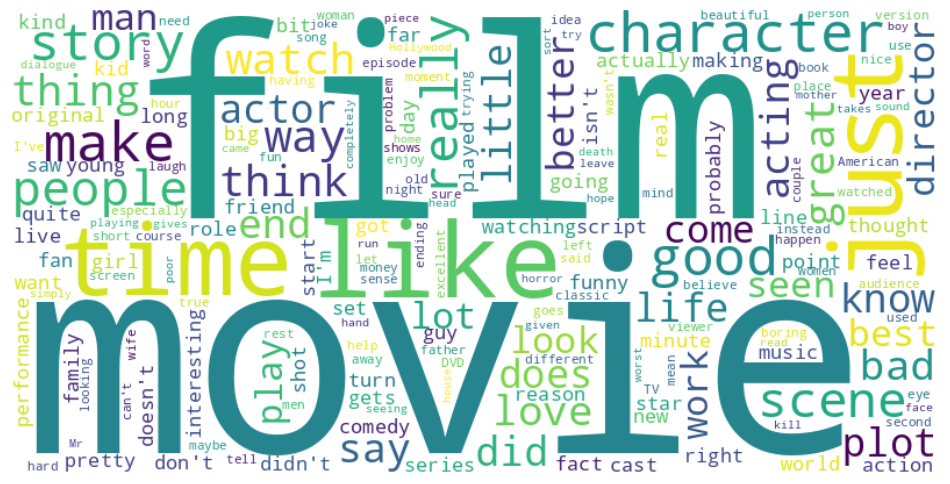

In [11]:
# Concatenate the text review data
reviews = " ".join(df['text'])

# Create the word cloud image
word_cloud = WordCloud(background_color='white',
                      stopwords = ENGLISH_STOP_WORDS,
                      width=800,
                      height=400)

# Generate the word cloud using the review data
word_cloud.generate(reviews)

# Display the word cloud
plt.rcParams["figure.figsize"]= (12,8)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Pre-processing the review text
To pre-process the text, we will use the term frequency-inverse document frequency, or TfIdf. TfIdf is a way of calculating the importance of words in a collection of different sets of text (or documents).
TfIdf has the advantages of:

- Highlighting words that are common within a document but not across documents.
- Returning low scores for words common across all reviews (e.g., movie in movie reviews).
- Penalizing frequent words so we don't need to worry about stop words as much.


In [21]:
# Specify the word pattern
pattern = r"[a-zA-Z]+"

# Build the vectorizer and fit to the text data
vect = TfidfVectorizer(
    token_pattern=pattern,
    stop_words=ENGLISH_STOP_WORDS,
    ngram_range=(1,2),
    max_features=500
)

vect.fit(df['text'])

# Create sparse matrix from the vectorizer
tokenized_features = vect.transform(df['text'])

# Create a DataFrame of the new features
features = pd.DataFrame(data = tokenized_features.toarray(),
                        columns = vect.get_feature_names_out())


### Feature Engineering

With the inclusion of additional features like review length and average word length, the model gains valuable insights into the structure of the reviews. Review length can indicate the depth of the sentiment, while average word length might offer insights into the complexity of language used. These features provide essential context, aiding the model in making more precise sentiment predictions.

In [22]:
# Generate a number of different length metrics based on the text
df['char_count'] = df['text'].str.count(r"\S")
df['word_count'] = df['text'].str.count(pattern)
df['avg_word_length'] = df['char_count'] / df['word_count']

# Preview our new columns
df.sample(3)

,text,label,char_count,word_count,avg_word_length
3138,I mean seriously what group would sing about a...,0,615,144,4.270833
2704,"As you may know, the subject here was to ask e...",1,2074,440,4.713636
501,Something does not work in this movie. There a...,0,172,33,5.212121


## Model and Evaluation

This project will use a simple `RandomForestClassifier()`and calculate the classification metrics using a test set and the predicted values.

In [27]:
# Define X and y
X=pd.concat([features, df.loc[:, "char_count":]], axis=1)
y= df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

# Train a random forest classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

# Predict the labels
y_pred = rfc.predict(X_test)

# Print classification metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       523
           1       0.76      0.80      0.78       477

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.78      1000
weighted avg       0.79      0.79      0.79      1000



A confusion matrix is used to gain additional insights into the performance of the classification. This allows us to see what percentage of predictions were true positives, true negatives, false positives, and false negatives.

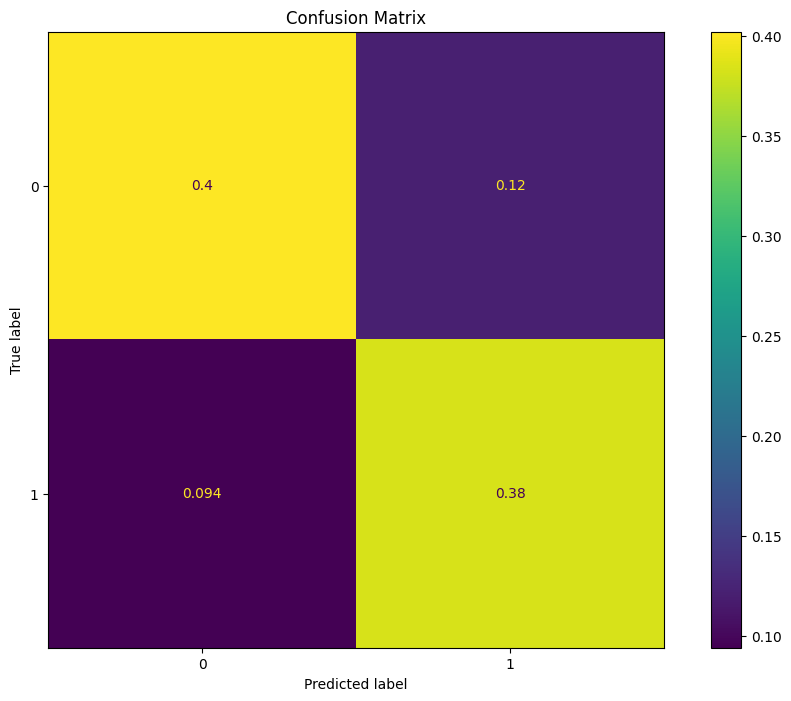

In [29]:
# Print a confusion matrix for the model
ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test, normalize='all')
plt.title('Confusion Matrix')
plt.show()

### Feature Importance

In [31]:
# Create a DataFrame of the features and their importances
pd.DataFrame(
    {"feature":X.columns, "importance": rfc.feature_importances_}
).sort_values(by='importance', ascending=False)

,feature,importance
27,bad,0.045045
487,worst,0.031163
174,great,0.021562
415,t,0.016111
25,awful,0.015166
...,...,...
420,talent,0.000416
482,words,0.000411
160,game,0.000385
17,aren,0.000374


### Conclusion

The model exhibited commendable performance, achieving nearly 80% accuracy. Despite this, there is room for enhancement. The model struggled with 2-gram sentiments, such as 'not good,' misclassifying them as 'bad.' To address this, incorporating n-grams in future iterations is recommended. This approach will likely refine the model's understanding, leading to more accurate sentiment predictions.